In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets
from torchvision import transforms
from torch import nn, optim

In [2]:
print(torch.__version__)

1.7.1+cu101


In [3]:
from skimage import io
import warnings
warnings.filterwarnings('ignore')
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

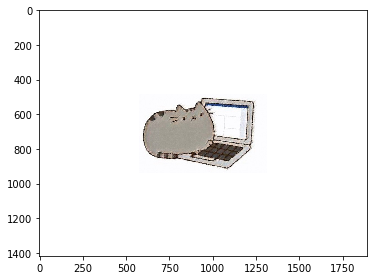

In [4]:
image = io.imread('laptop_cat.png')
io.imshow(image)

## Rotating image by 45 degrees

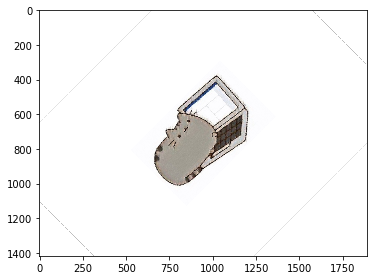

In [5]:
rotated_img = rotate(image,angle = 45)
io.imshow(rotated_img)

## Flip left to right


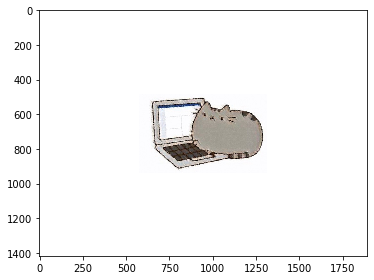

In [6]:
flip_img = np.fliplr(image)
io.imshow(flip_img)

## Blur the image

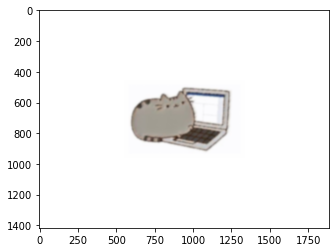

In [7]:
blurred_img = gaussian(image, sigma = 5, multichannel= True)
plt.imshow(blurred_img)

**Transforms** are common image transformations.

Transforms can be Image Resize, converting an image tensor or the augmentation techniques we have seen above. 

-> All transformations accept PIL Image, Tensor Image or batch of Tensor Images as input.


**transform.Compose** clubs all the transforms provided to it. All the transforms in the transforms.Compose are applied to the input one by one.

Transforms are done on batches and randomly based on the probability provided by us for that specific transformation.

In [8]:
import PIL
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.GaussianBlur(3,sigma=(0.1,2.0)),
                                transforms.RandomRotation(45,resample=PIL.Image.BILINEAR)]
                                )

In [9]:
trainset = datasets.FashionMNIST('./data',download=True,train=True,transform=transform)
testset = datasets.FashionMNIST('./',download=True,train = False, transform=transform)

#Defining trainloader and testloader
The transforms operations are applied to your original images at every batch generation. 

So your dataset is left unchanged, only the batch images are copied and transformed every iteration.

In [10]:
trainLoader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testLoader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

In [11]:
len(testset)

10000

## **Visualizing the Training Images**

In [12]:
dataiter = iter(trainLoader)
images,labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [13]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(1,4,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride=2),
        nn.Conv2d(4,4,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride=2)
    )
    self.linear_layers = nn.Sequential(
        nn.Linear(4*7*7,10)
    )
  def forward(self,x):
     x = self.cnn_layers(x)
     x = x.view(x.size(0),-1)
     x = self.linear_layers(x)
     return x

In [14]:
model = Net()
optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
#Check if GPU is available; if it is, then we will use it
if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()

print(model)  

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


## Training 

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

Epoch 2- training Loss: 0.9521846018239125
Epoch 3- training Loss: 0.7938288985602637
Epoch 4- training Loss: 0.7591204546344306
Epoch 5- training Loss: 0.7448710545675078
Epoch 6- training Loss: 0.7398381354902853
Epoch 7- training Loss: 0.7296828155769214
Epoch 8- training Loss: 0.7270012012422721
Epoch 9- training Loss: 0.7165426552168596
Epoch 10- training Loss: 0.7122384307862345


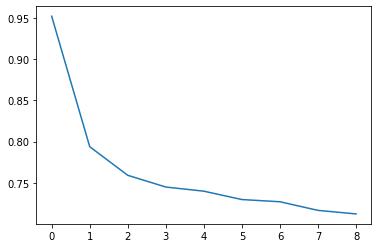

In [15]:
loss_values = []
for i in range(1,10):
  running_loss = 0
  for images,labels in trainLoader:
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  else: #Execute immediately after for loop
    print("Epoch {}- training Loss: {}".format(i+1,running_loss/len(trainLoader)))
    loss_values.append(running_loss/len(trainLoader))

#plot the loss
plt.plot(loss_values)

## Results

Getting Predictions on test set and measuring the performance

In [16]:
correct_count, all_count = 0,0
for images,labels in testLoader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    img = images[i].view(1,1,28,28)
    with torch.no_grad():#since we don't need backprop;doing this can speed up the computation
      logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if true_label == pred_label:
      correct_count += 1
    all_count += 1

print("Model Acc = ", correct_count/all_count)

Model Acc =  0.6521
